In [2]:
# import os
# import json
# import numpy as np
# import pandas as pd
# import networkx as nx
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import scipy.stats as sst

In [3]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../scripts/')
import plottingUtils as plu

import networkx as nx
import seaborn as sns

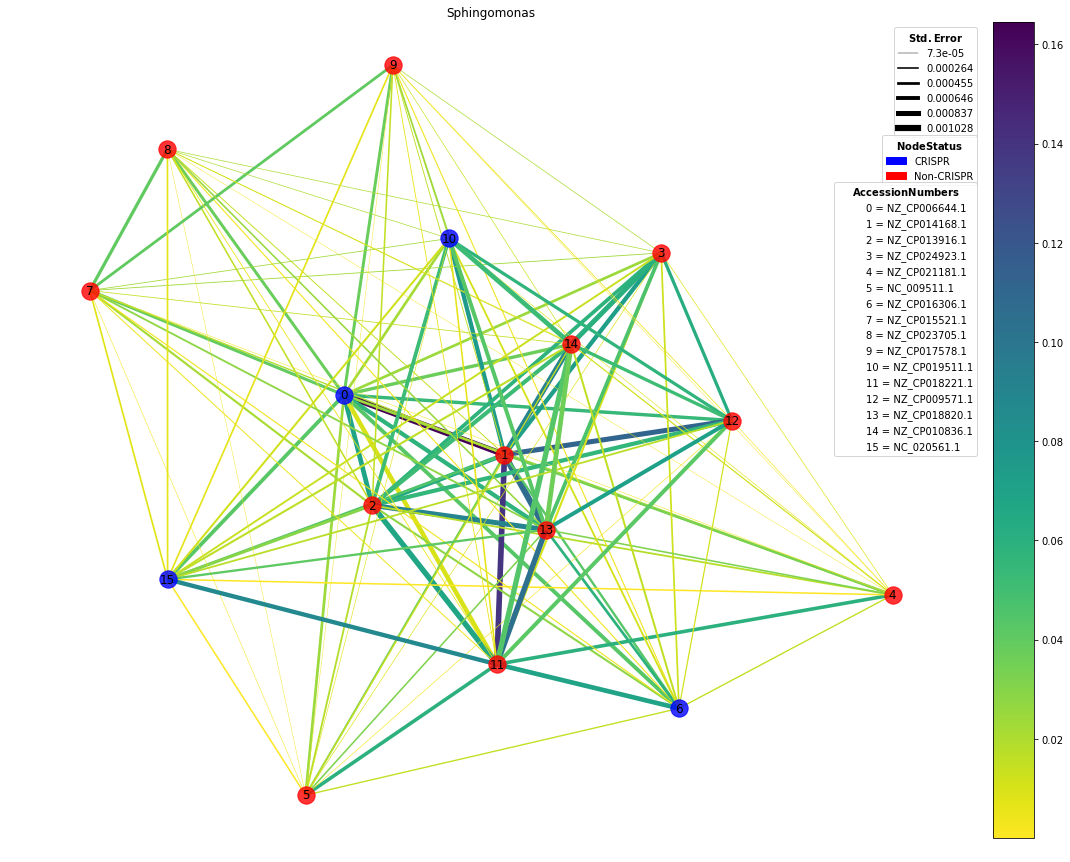

In [4]:
#mpl.rc('text',usetex=False)
dpi=50
basefigdir = '/home/sidreed/thesis_SidReed/writing/nontext/figures'
rnetpath = '/home/sidreed/thesis_SidReed/plotnets/Sphingomonas_plot_network.json'
df,net,name = plu.loadnetwork(rnetpath,returnname=True)
plu.plotNetwork(net,df,
              seed=19,
              dpi=dpi,
              name=name,
              save='{}/network.png'.format(basefigdir),
              layout=nx.spring_layout,
              width_scaling=6000)

In [5]:
mdf,stats = plu.loadReports()
mdf.head()
finaldf = plu.finaldf(mdf,stats).drop('Streptomyces')
finaldf.head()
nohdf = finaldf[(finaldf['c_indel'] != 100) & (finaldf['nc_indel'] != 100)]
sns.set_palette("coolwarm")

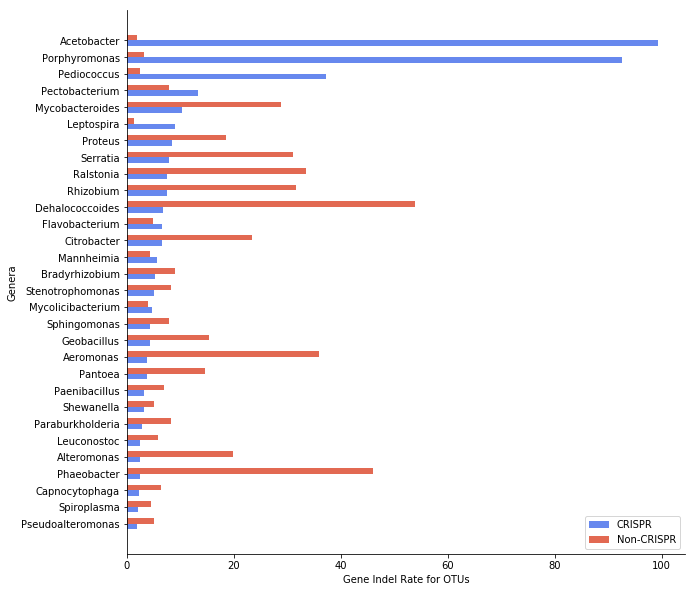

In [6]:
plu.multiBarPlot(nohdf,['c_indel','nc_indel']
            ,'Gene Indel Rate for OTUs',width=1,dpi=dpi,
            file='{}/c_nc_indel_bar.png'.format(basefigdir))

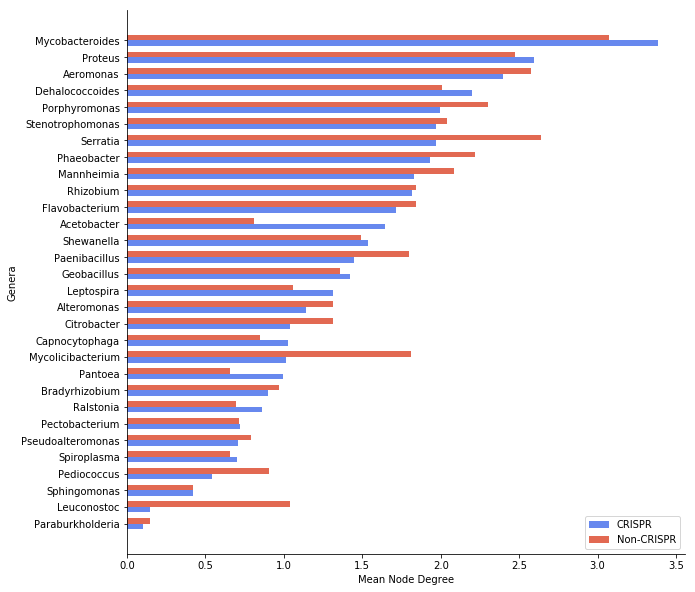

In [7]:
plu.multiBarPlot(nohdf,['c_mean_deg','nc_mean_deg'],
                 'Mean Node Degree',width=1,dpi=dpi,
                file='{}/c_nc_deg_bar.png'.format(basefigdir))

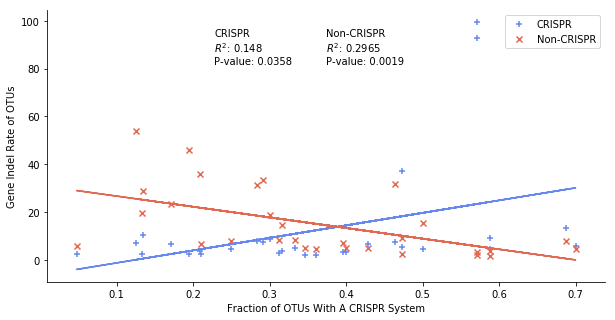

In [8]:
plu.rateVsCFrac(nohdf,dpi=dpi,
  file='{}/cfrac_cncRateDiff_scattter.png'.format(basefigdir))

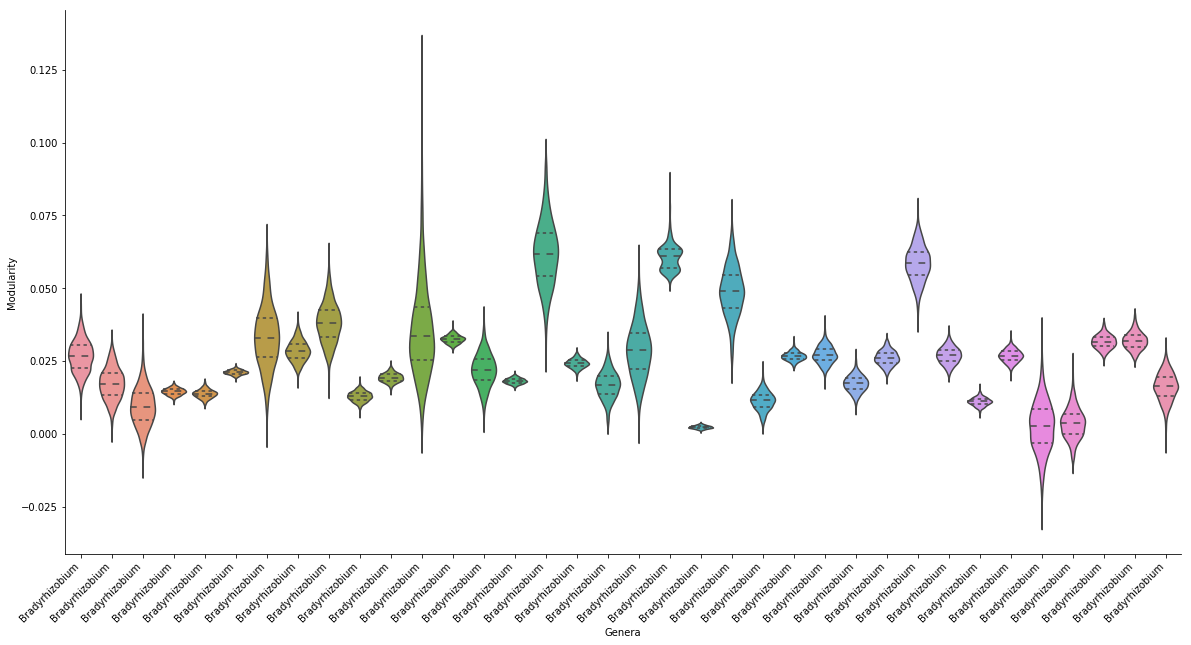

In [9]:
plu.violinPlot(stats,col='modularity',dpi=dpi,
                 file='{}/mod_violin.png'.format(basefigdir))

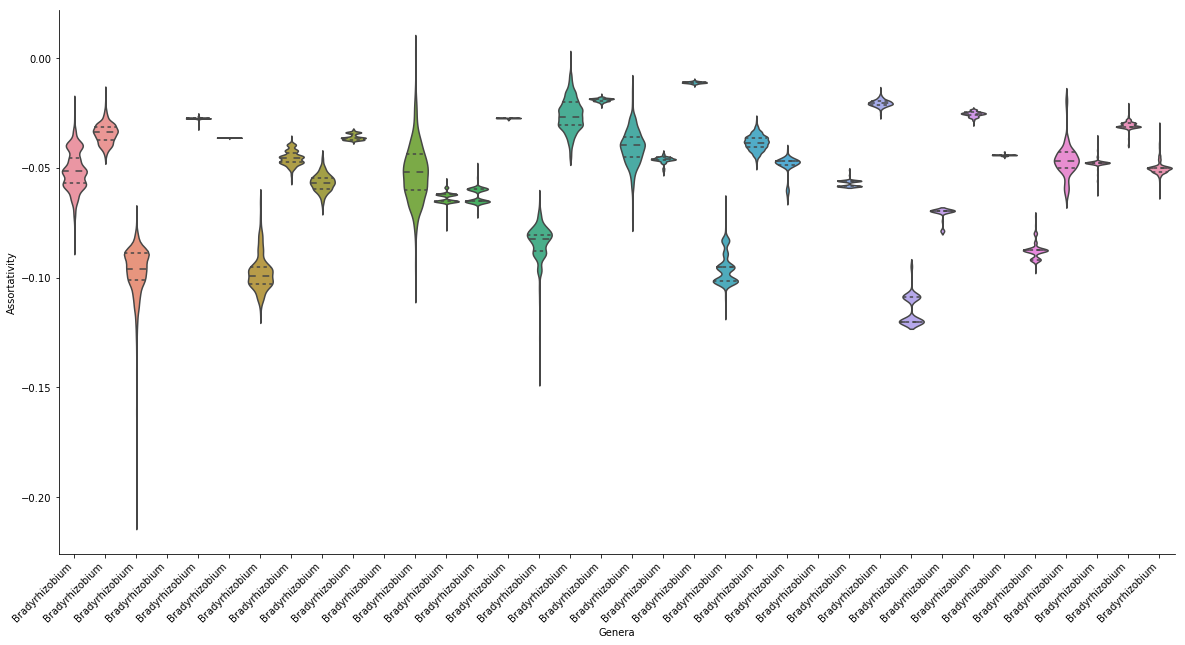

In [10]:
plu.violinPlot(stats,col='assortativity',dpi=dpi,
               file='{}/asst_violin.png'.format(basefigdir))

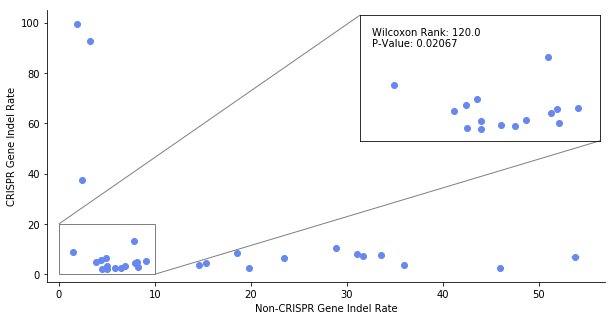

In [11]:
plu.cVsncRate(nohdf,dpi=dpi,
              file='{}/c_nc_rate_scatter'.format(basefigdir))

/home/sidreed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sidreed/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


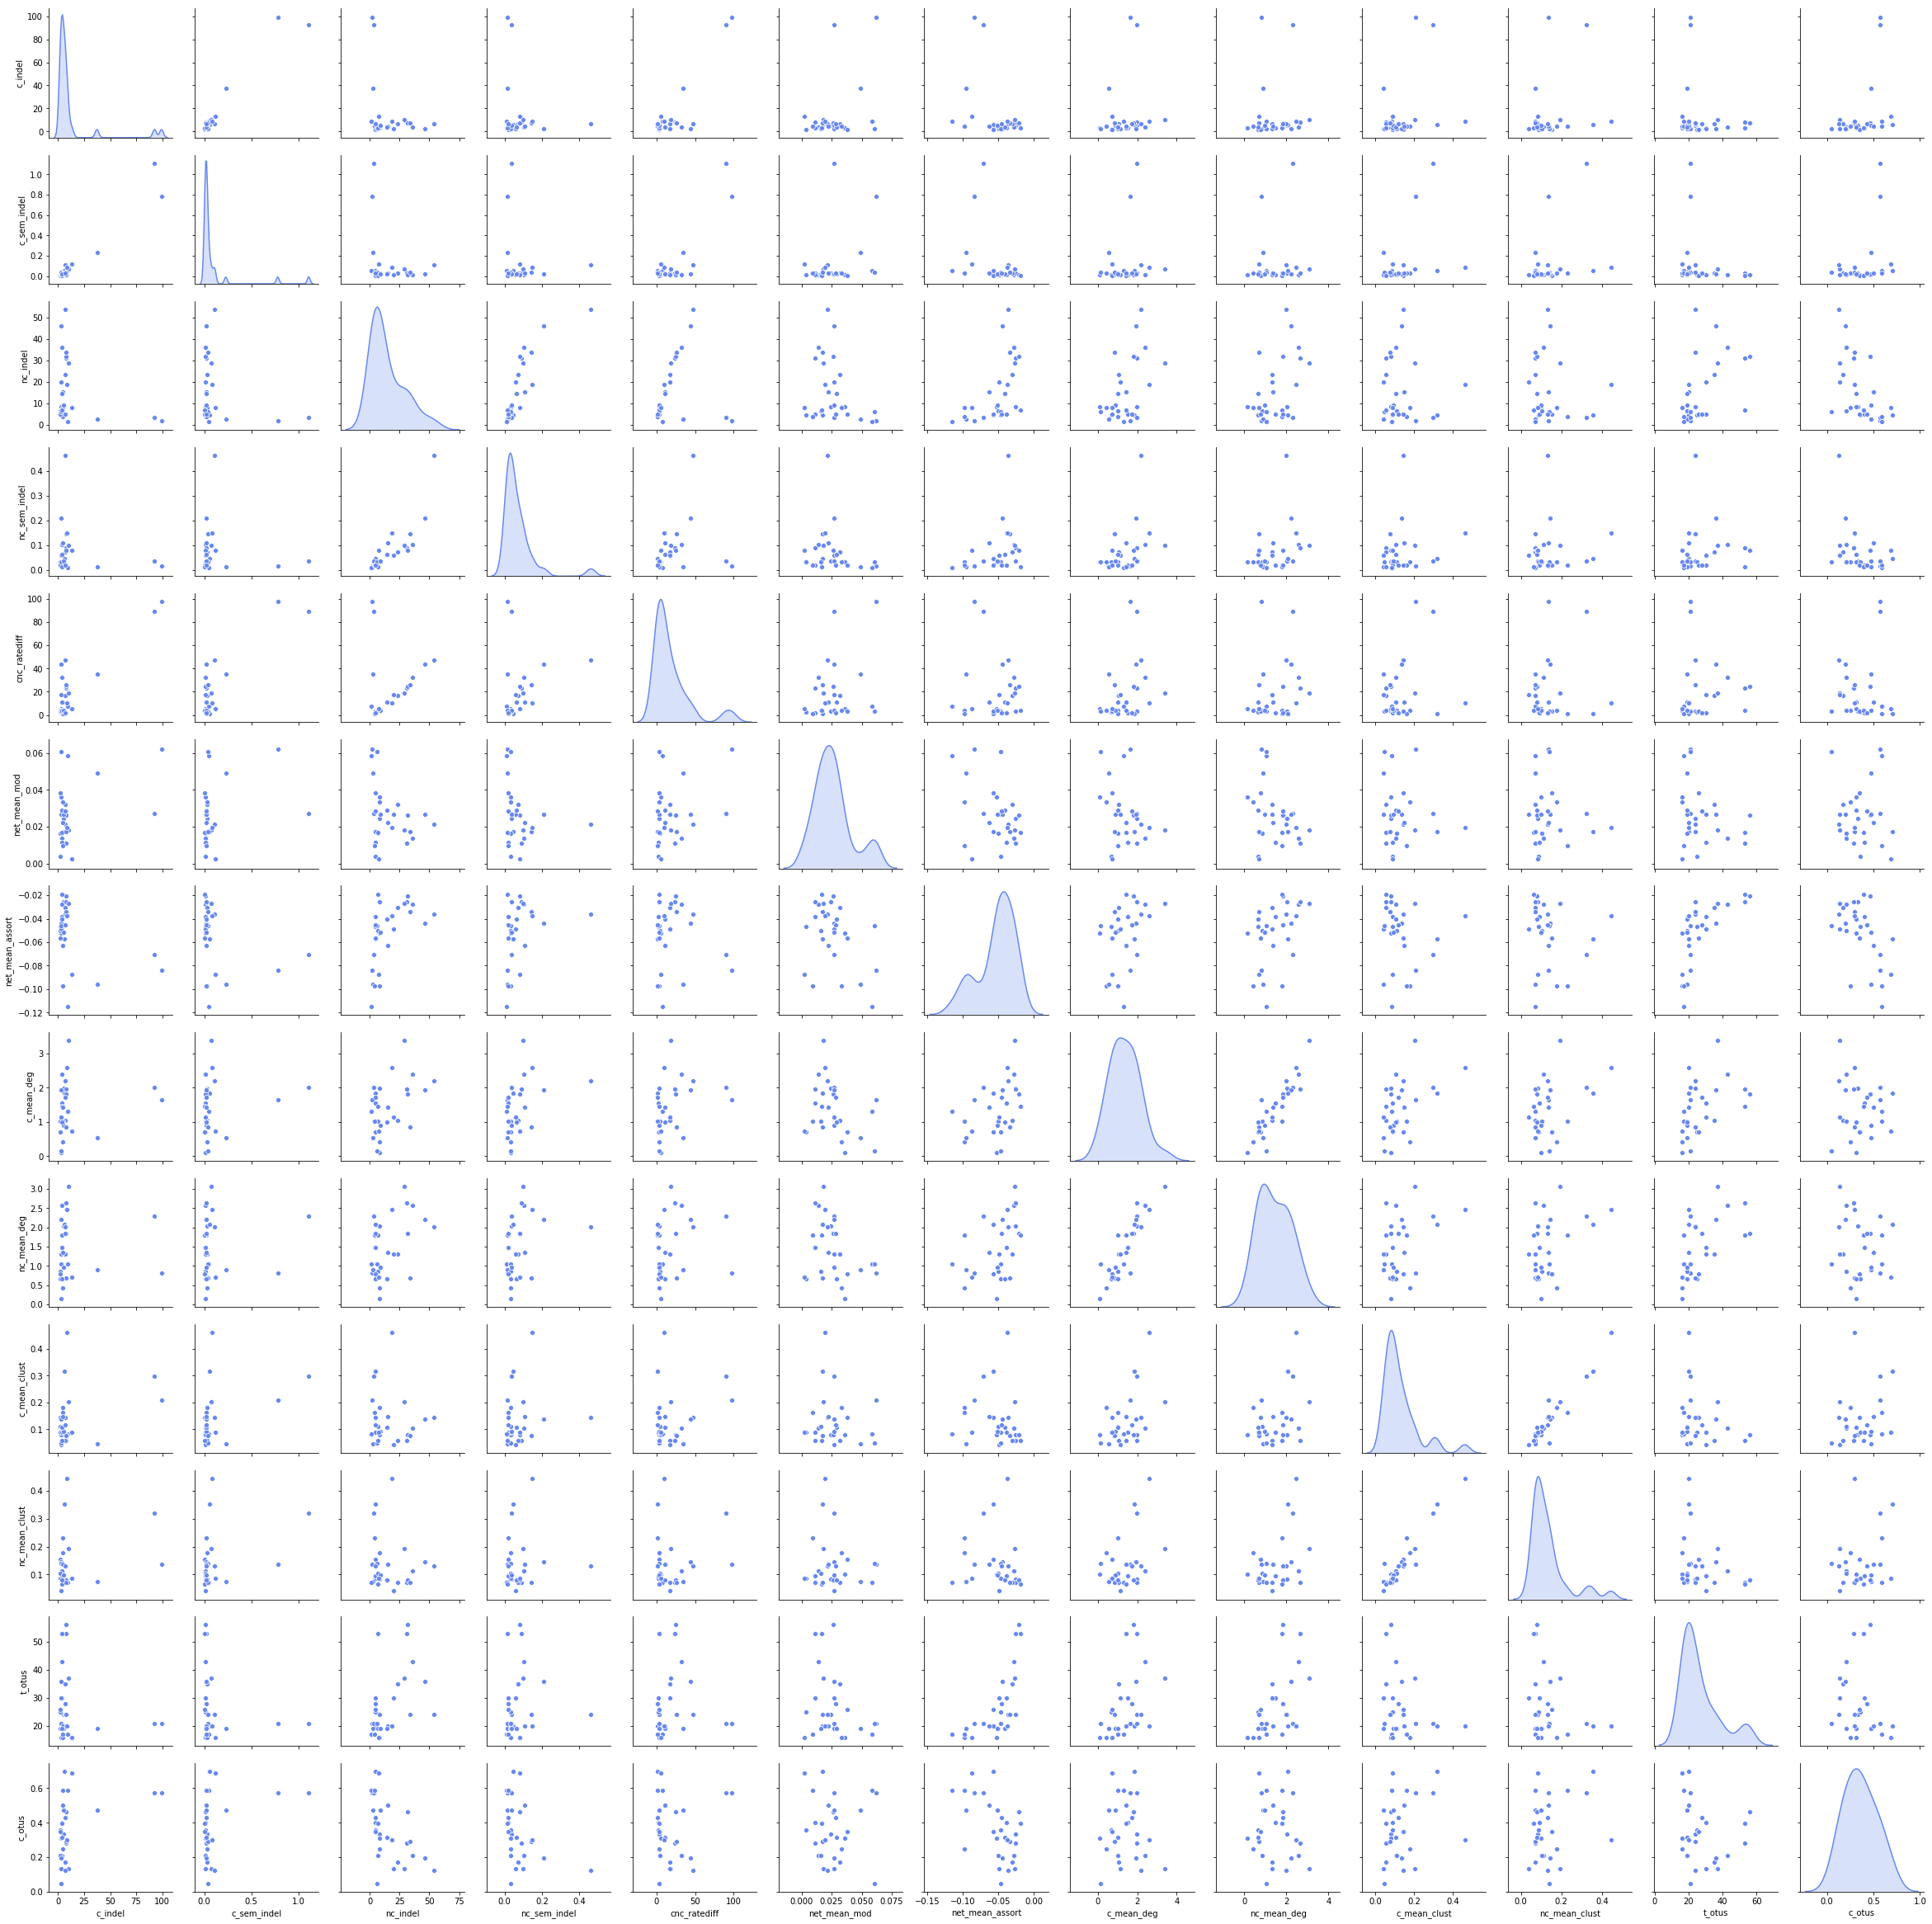

In [12]:
# nohdf.head()
nohdf['genus'] = nohdf.index
# fig,ax = plt.subplots(figsize=(10,10))
g = sns.pairplot(nohdf,diag_kind='kde')
g.savefig('{}/pairplot.png'.format(basefigdir),
        dpi=dpi,format='png',frameon=False)

In [13]:
nohdf.iloc[:2].transpose()

genus,Stenotrophomonas,Aeromonas
c_indel,5.01977,3.82704
c_sem_indel,0.0260724,0.0164869
nc_indel,8.18437,35.9707
nc_sem_indel,0.0366048,0.101814
cnc_ratediff,3.1646,32.1437
net_mean_mod,0.0242362,0.0137976
net_mean_assort,-0.0257326,-0.0273803
c_mean_deg,1.97122,2.39492
nc_mean_deg,2.04097,2.57454
c_mean_clust,0.0805208,0.105676
